# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [12]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [13]:
#df.groupby('email')['article_id'].value_counts()
#df.groupby('article_id')['email'].value_counts()
#df['email'].value_counts()
#user_interaction = df.groupby(['email','article_id']).size().unstack(fill_value=0)
#num_interaction_per_user = user_interaction.sum(axis=1)

In [16]:
np.setdiff1d(list(df['email'].unique()), list(df['email'].value_counts().index))

array(['nan'], 
      dtype='<U40')

In [17]:
no_of_articles_user_interacted = list(df['email'].value_counts()) #Allows repeated articles
print("Length of users (based on articles interaction)",len(no_of_articles_user_interacted))
print("Length of users", len(df['email'].unique()))
print("Number of users that read only 1 article: ",np.sum([i if i==1 else 0 for i in no_of_articles_user_interacted]))
print("Number of users that read more than 1 article: ",np.sum([1 if i>1 else 0 for i in no_of_articles_user_interacted]))

print("Median of number of articles read by all users: ",np.median(no_of_articles_user_interacted))
print("Maximum number of user-article interaction: ",max(no_of_articles_user_interacted))

Length of users (based on articles interaction) 5148
Length of users 5149
Number of users that read only 1 article:  1416
Number of users that read more than 1 article:  3732
Median of number of articles read by all users:  3.0
Maximum number of user-article interaction:  364


In [18]:
len(df[df['email'].isna()])

17

There are nan values in the email column in the dataset, hence number of users is shown as 5149 instead of 5148 (number of unique users that interacted with articles).

Out of 5148 users, 1416 users read only 1 article, while remaining read more than 1

Lets plot a histogram of number of interactions performed by an user, for ueser that interacted more than once.
Since few ouliers like 364 interactions by a user, makes it difficult to visualize the distribution, we only consider those values with frequency more than 2

In [19]:
l = [i for i in no_of_articles_user_interacted if i>1 and no_of_articles_user_interacted.count(i) > 2 ]
print(len(l))

3666


In [20]:
print("Maximum: ",np.max(l))
print("Minimum (after removing 1 and frquency>3)",np.min(l))
print("Mean",np.mean(l))
print("Median (after removing 1 and frquency>3)",np.median(l))

Maximum:  84
Minimum (after removing 1 and frquency>3) 2
Mean 10.246863066
Median (after removing 1 and frquency>3) 6.0


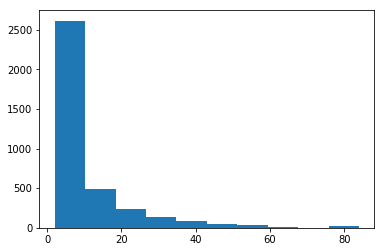

In [21]:
plt.hist(l) #, range(2,50)
plt.show()

From the histogram of number of interactions is mostly 1 followed by 2

In [22]:
user_interaction = df.groupby(['email','article_id']).size().unstack(fill_value=0)
num_interaction_per_user = user_interaction.sum(axis=1)

In [23]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(no_of_articles_user_interacted)# 50% of individuals interact with _____ (including duplicates) number of articles or fewer.
max_views_by_user = max(no_of_articles_user_interacted)# The maximum number of user-article interactions by any 1 user is ______.

print(f"50% of individuals interact with {median_val} (including duplicates) number of articles or fewer.")
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3.0 (including duplicates) number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [24]:
# Find and explore duplicate articles
#List duplicates
print("Number of duplicate rows: ",len(df[df.duplicated()]))

Number of duplicate rows:  12311


In [25]:
# Remove any rows that have the same article_id - only keep the first
df_rd =  df.drop_duplicates(subset=['article_id', 'email'], keep='first') #Removing only rows where user interacted with articls more than once
print("Before removing duplicates: ",df.shape)
print("Print after removing duplicates: ",df_rd.shape)

Before removing duplicates:  (45993, 3)
Print after removing duplicates:  (33682, 3)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [26]:
#df_rd['email'].isna() == False
#len(df.groupby(['email','article_id']).size())
#len(no_of_articles_user_interacted)

In [27]:
user_interaction = df.groupby(['email','article_id']).size().unstack(fill_value=0)
num_interaction_per_user = user_interaction.sum(axis=1)

In [30]:
unique_articles = len(df_rd[df_rd['email'].isna() == False]['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(df_content['article_id'].unique()) # The number of unique articles on the IBM platform
unique_users = len(no_of_articles_user_interacted)# The number of unique users
user_article_interactions = len(df) # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [31]:
most_viewed_article_id = str(user_interaction.sum(axis=0).idxmax())# The most viewed article in the dataset as a string with one value following the decimal 
max_views = user_interaction.sum(axis=0).max()# The most viewed article in the dataset was viewed how many times?

In [32]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [33]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [34]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [35]:
#df_content.head()
#df_content.loc[df_content['article_id'].isin(list(article_interactions.head()['article_id']))]
#df.loc[df['article_id'].isin(list(article_interactions.head()['article_id']))]['title'].unique()

In [38]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = []
    article_interactions = pd.DataFrame()
    article_interactions['article_id'] = df['article_id'].value_counts().index
    article_interactions['interactions_count'] = list(df['article_id'].value_counts())
    article_interactions = article_interactions.sort_values('interactions_count',ascending=False)
    
    for i in list(article_interactions.head(n)['article_id']):
        top_articles.append(df_rd.loc[df_rd['article_id']==i]['title'].unique()[0])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = []
    article_interactions = pd.DataFrame()
    article_interactions['article_id'] = df['article_id'].value_counts().index
    article_interactions['interactions_count'] = list(df['article_id'].value_counts())
    article_interactions = article_interactions.sort_values('interactions_count',ascending=False)
    
    top_articles= list(article_interactions.head(n)['article_id'])
        
    

 
    return top_articles # Return the top article ids

In [39]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [40]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [41]:
print("Max views for an article by an user: ",user_interaction.max())

print("Max views for an article by an user after clipping:",user_interaction.max())

Max views for an article by an user:  article_id
0.0        3
2.0        3
4.0        1
8.0        2
9.0        1
12.0       7
14.0       1
15.0       1
16.0       2
18.0       3
20.0       8
25.0       1
26.0       4
28.0       2
29.0      15
30.0       1
32.0       2
33.0       5
34.0       3
36.0       1
39.0       3
40.0       2
43.0      15
48.0       1
50.0       5
51.0       3
53.0       4
54.0       1
57.0       2
58.0       1
          ..
1412.0     4
1414.0     1
1415.0     2
1416.0     7
1418.0     2
1419.0     1
1420.0     4
1421.0     1
1422.0     8
1423.0     7
1424.0     3
1425.0     3
1426.0     5
1427.0    22
1428.0     5
1429.0    35
1430.0     8
1431.0    22
1432.0     9
1433.0     6
1434.0     4
1435.0     6
1436.0     9
1437.0    14
1439.0     5
1440.0     2
1441.0     2
1442.0     1
1443.0     5
1444.0     1
Length: 714, dtype: int64
Max views for an article by an user after clipping: article_id
0.0        3
2.0        3
4.0        1
8.0        2
9.0        1
12.0

In [42]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_interaction = df.groupby(['user_id','article_id']).size().unstack(fill_value=0)
    user_interaction = np.array(user_interaction)
    user_interaction[user_interaction>1] = 1
    
    return user_interaction # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [43]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[0] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [44]:
len(user_item[0])

714

In [45]:
simi = {1:5, 6:2, 3:4}
dict(sorted(simi.items(), key=lambda item: item[1],reverse=True))

{1: 5, 3: 4, 6: 2}

In [46]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    def cosine_dist(a,b):
        a = np.array(a)
        b = np.array(b)
        return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
            
    
    user_idx = user_id-1
    simi = {}
    for i in range(len(user_item)):
        dist = cosine_dist(user_item[user_idx],user_item[i])
        simi[i] = dist            

    # sort by similarity
    simi_sorted = dict(sorted(simi.items(), key=lambda item: item[1],reverse=True))

    
    # remove the own user's id
    simi_sorted.pop(user_idx, None)
    # create list of just the ids
    most_similar_users = [i+1 for i in simi_sorted.keys()]
   
    
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [47]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 46, 4201, 253, 824, 5034, 5041, 136, 2305, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 253, 824]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [48]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    for i in article_ids:
        #try:
        #    article_names.append(df_content.loc[df_content['article_id']==float(i)]['doc_full_name'].unique()[0])
        #except:
        article_names.append(df.loc[df['article_id']==float(i)]['title'].unique()[0])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids=[] 

    user_interactions = list(user_item[user_id-1])
  
    articles_list = list(df.groupby(['user_id','article_id']).size().unstack(fill_value=0).columns)
    for aid,useen in zip(articles_list, user_interactions):
        if(useen==1):
            article_ids.append(str(aid))
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    u_seen_id, u_seen_name = get_user_articles(user_id, user_item=user_item)
    similar_users = find_similar_users(user_id, user_item=user_item)
    recs = []
    for su in similar_users:
        su_seen_id, su_seen_name = get_user_articles(su, user_item=user_item)
        new_id = np.setdiff1d(su_seen_id, u_seen_id)

        recs.extend(new_id)
        if(len(recs)>=m):
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [49]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'the pandas data analysis library',
 'access mysql with r',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'country statistics: airports',
 'model bike sharing data with spss',
 'pixieapp for outlier detection',
 'predicting churn with the spss random tree algorithm',
 'the nurse assignment problem']

In [50]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [51]:
def cosine_dist(a,b):
        a = np.array(a)
        b = np.array(b)
        return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    user_idx = user_id-1
    num_interaction = []
    simi = {}
    for i in range(len(user_item)):
        dist = cosine_dist(user_item[user_idx],user_item[i])
        simi[i] = dist            

    # sort by similarity
    simi_sorted = dict(sorted(simi.items(), key=lambda item: item[1],reverse=True))
    simi_sorted.pop(user_idx, None)

    neighbours_id = [i+1 for i in simi_sorted.keys()]
    similarity = [simi_sorted[i] for i in simi_sorted.keys()]
    num_interaction = [len(df[df['user_id']==i]) for i in neighbours_id]
    
    neighbors_df = pd.DataFrame()
    neighbors_df['neighbours_id'] = neighbours_id
    neighbors_df['similarity'] = similarity
    neighbors_df['num_interaction'] = num_interaction
    
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interaction'], ascending=False)
    return neighbors_df

def sort_articles(id_list,sorted_articles):
    map_id_interaction = {}
    for id_ in id_list:
        map_id_interaction[id_] = list(sorted_articles[sorted_articles['article_id']==float(id_)]['interactions'])[0]
        
    map_id_interaction_sorted = dict(sorted(map_id_interaction.items(), key=lambda item: item[1],reverse=True))
    return list(map_id_interaction.keys())

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = []
    
    sorted_articles = pd.DataFrame()
    sorted_articles['article_id'] = df['article_id'].value_counts().index
    sorted_articles['interactions'] = list(df['article_id'].value_counts())
    sorted_articles = sorted_articles.sort_values(by=['interactions'], ascending=False)
    #sorted_articles.head()

    ndf = get_top_sorted_users(user_id, df=df, user_item=user_item)
    u_seen_id, u_seen_name = get_user_articles(user_id, user_item=user_item)
    
    for su in list(ndf['neighbours_id']):
        su_seen_id, su_seen_name = get_user_articles(su, user_item=user_item)
        new_id = np.setdiff1d(su_seen_id, u_seen_id)
        sorted_new_ids = sort_articles(new_id,sorted_articles)

        recs.extend(sorted_new_ids)
        if(len(recs)>=m):
            break
        pass
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [52]:
sorted_articles = pd.DataFrame()
sorted_articles['article_id'] = df['article_id'].value_counts().index
sorted_articles['interactions'] = list(df['article_id'].value_counts())
sorted_articles = sorted_articles.sort_values(by=['interactions'], ascending=False)
sorted_articles.head()

,article_id,interactions
0,1429.0,937
1,1330.0,927
2,1431.0,671
3,1427.0,643
4,1364.0,627


In [53]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1162.0', '1165.0', '1185.0', '1293.0', '1165.0', '1185.0', '1293.0', '254.0', '1271.0', '1328.0']

The top 10 recommendations for user 20 are the following article names:
['analyze energy consumption in buildings', 'analyze precipitation data', 'classify tumors with machine learning', 'finding optimal locations of new store using decision optimization', 'analyze precipitation data', 'classify tumors with machine learning', 'finding optimal locations of new store using decision optimization', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'customer demographics and sales', 'income (2015): united states demographic measures']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [54]:
### Tests with a dictionary of results
ans1 = get_top_sorted_users(1, df=df, user_item=user_item)
ans2 = get_top_sorted_users(131, df=df, user_item=user_item)

user1_most_sim = ans1['neighbours_id'][0]# Find the user that is most similar to user 1 
user131_10th_sim = ans2['neighbours_id'][7]# Find the 10th most similar user to user 131

For some reason the answer expected for 10th most similar user to user 131 is actually the 7th most similar user.
Maybe there was some updates to the dataset, that was not reflected to the test cases, as all previous test passed.

In [55]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, we cannot use collaborative filtering (comparing with other users to find most similar users) because there is no data.
Since we have no information on movies, we cannot use content based filtering also.
Hence we can use popularity/ranking based recommendation, where the most popular article is recommended.
This function get_top_articles(n, df=df) can be used to make the recommendations.


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [56]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(n=10, df=df)# Your recommendations here
new_user_recs = [str(i) for i in new_user_recs]


In [57]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [61]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [62]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [63]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)# use the built in to get the three matrices

In Singular Value Decomposition we split the matrix consisting of the number of user-article interactions into its factors, U,S,V.
We consider the U matrix, to describe the users, the V matrix to describe the articles, and the S matrix to containt features (latent variables) that allows us to multiply the user and articles matrices.

For our current use case, whre we are focussing on the number of times an user interacts with an article, there is no scope for null value, as it defaults to 0. Hence due to the absence of null value we can directly use the SVD algorithm provided by numpy.linalg.

In the lessons, we focussed on creating recommendations for movies based on user reviews. Here the user-movie matrix is filled with ratings that the user gave for a movie. Since not all users have seen and rated all movies, the matrix is sparse with lots of null values. Linear SVD fails here, as it cannot handle null values. 

Hence Funk SVD was proposed and used to tackle this problem. In Funk SVD, we create two matrices, one for users and the other for movies, with the other dimension being the number of latent factors considered. These are filled with random numbers, and iteratively updated using the values that are provided in the original rating matrix, and gradient descent.
After few iterations, we obtain complete matrices, for users and movies which can be used to fill in the missing values, and thus predict ratings for movies, the user has not seen yet.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

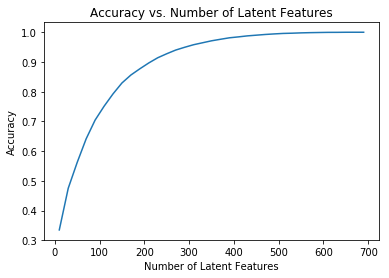

In [64]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [65]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = df_train.groupby(['user_id','article_id']).size().unstack(fill_value=0)#create_user_item_matrix(df_train)
    user_item_test = df_test.groupby(['user_id','article_id']).size().unstack(fill_value=0)##create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [74]:
train_users = df_train['user_id'].unique()
test_users = df_test['user_id'].unique()

print("Number of users in test data",len(test_users))
print("Number of users in train data",len(train_users))
print("Number of new users in test data, who are not in train data",len(np.setdiff1d(test_users,train_users)))


Number of users in test data 682
Number of users in train data 4487
Number of new users in test data, who are not in train data 662


In [75]:
train_articles = df_train['article_id'].unique()
test_articles = df_test['article_id'].unique()

print("Number of articles in test data",len(test_articles))
print("Number of articles in train data",len(train_articles))
print("Number of new articles in test data, which are not in train data",len(np.setdiff1d(test_articles,train_articles)))


Number of articles in test data 574
Number of articles in train data 714
Number of new articles in test data, which are not in train data 0


In [76]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a, # letter here, 
    'How many movies can we make predictions for in the test set?':b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [56]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)# fit svd similar to above then use the cells below

In [211]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

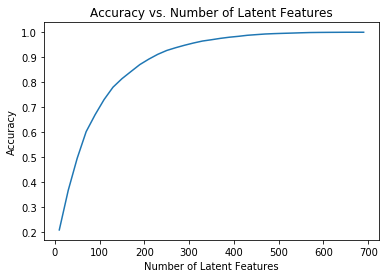

In [57]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [58]:
#sum_errs.[np.min(sum_errs)]
num_laten_features = num_latent_feats[sum_errs.index(min(sum_errs))]
#sum_errs.index(min(sum_errs))
print("Number of latent features to select based on training data: ",num_laten_features )

Number of latent features to select based on training data:  670


As number of articles in test data is only 574, we cannot take latent features as 670. Hence we take latent features as 574

In [59]:
k = 574
u_test, s_test, vt_test = np.linalg.svd(user_item_test, full_matrices=True)
s_new, u_new, vt_new = np.diag(s_train[:k]), u_test[:, :k], vt_test[:k, :]
user_item_est_test = np.around(np.dot(np.dot(u_new, s_new), vt_new))

In [60]:
user_item_est_test.shape

(682, 574)

In [63]:
np.dot(u_new, s_new).shape

(682, 574)

In [64]:
vt_new.shape


(574, 574)

In [61]:
# 670 LATENT FEATURES -> 574
print(k)
diffs =  np.subtract(np.array(user_item_est_test), np.array(user_item_test))
    
# total errors and keep track of them
err = np.sum(np.sum(np.abs(diffs)))
rmse= np.sqrt(np.mean(np.abs(diffs)**2))
print("Error: ",err)
print("Root mean square error: ",rmse)

574
Error:  11251.0
Root mean square error:  0.317976663212


We also try with lower number of features to find the difference in error

In [62]:
num_laten_features = 4#num_latent_feats[sum_errs.index(min(sum_errs))]
#sum_errs.index(min(sum_errs))
print("Number of latent features to select based on training data: ",num_laten_features )

Number of latent features to select based on training data:  4


In [65]:
k = 4
u_test, s_test, vt_test = np.linalg.svd(user_item_test, full_matrices=True)
s_new, u_new, vt_new = np.diag(s_train[:k]), u_test[:, :k], vt_test[:k, :]
user_item_est_test = np.around(np.dot(np.dot(u_new, s_new), vt_new))

In [66]:
# 4 LATENT FEATURES
print(k)
diffs = np.subtract(np.array(user_item_est_test), np.array(user_item_test))
    
# total errors and keep track of them
err = np.sum(np.sum(np.abs(diffs)))
rmse= np.sqrt(np.mean(np.abs(diffs)**2))
print("Error: ",err)
print("Root mean square error: ",rmse)
#print("Number of predictions missed: ",num_skips)
#print("Percentage of predictions missed: ",100*num_skips/(total_pred))

4
Error:  10450.0
Root mean square error:  0.23709501385


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Although train svm showed zero error when 670 latent variables are used, root mean square error(RMSE) is around 0.31 for test data. Comparing this to the model where only 4 latent features are considered, its intresting to note that the RMSE is around 0.23, which is lower than the previous model, where more latent features are considered. 
This difference might be due to overfitting on training data.


The SVM approach is usefull when we have data on user interactions and can effectively utilize the user and aricles relationships. In cases where there is scarcity of data, leading to the cold start problem, we can follow the techniqu af recommending the most popular articles.


Currently users have to manually search and identify the articles of their interest. One of the drawbacks in this approach is when the user is unaware of the exact topic they want to read, for example there might be multiple articles on SVM, but unless the user knows SVM is a technique that can be used for recommendation problems in machine learning, they might not read/interact with it. This further leads to low intractions from the user side.


By providing recommendation, we can continue to engage the user on the platform, and make them more interactive.
In the dataset provided, its observed that some users tend to visit the same article repeatedly, maybe for a refresher. I such cases, we can add the viewed article as a recommendation, under a different heading, like revise/lookback.

In [3]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM-final.ipynb'])

0